# Training the ANN on the dataset

**Workflow**
* Upload the training and test datsets to S3 
* Train and save the ANN model for later use
* Test model performance on test and validation data
* Re-architect the neural network as necessary based on the previous model's accuracy
* Upload new training data. Combine with original dataset
* Train the ANN on updated dataset
* Recommendation: Use the trained model to recommend features values such that collision does not occur 


*Note: We will not be deploying the model for inference since it is consumes time and is not required. Instead we load the saved model which is then used for predictions* 

Import libraries

In [1]:
import pandas as pd
import boto3
import sagemaker
import tensorflow as tf
import numpy as np
import os

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## Upload the training and test data to S3

In [4]:
# should be the name of directory you created to save your features data
data_dir = 'data/train_test'

# set prefix, a descriptive name for a directory  
prefix = 'capstone_edgecase'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-286722933665/capstone_edgecase


## Modelling

In [113]:
#!pygmentize source_tfkeras/train.py

We start with 2 hidden layers and 10 epochs to check the loss and also if the training process works without errors

## Create an Estimator

In [130]:
from sagemaker.tensorflow import TensorFlow
#model_dir = 's3://{}/{}/output/'.format(bucket, prefix) # you need add an estimator argument with this too

estimator = TensorFlow(entry_point="train.py",
                    source_dir="source_tfkeras",
                    role=role,
                    py_version = 'py37',
                    framework_version='2.4', # v2.5 is unsupported
                    script_mode=True,
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Train the Estimator

In [131]:
%%time
# Train your estimator on S3 training data

estimator.fit({'train': input_data})

2021-06-24 23:25:47 Starting - Starting the training job...
2021-06-24 23:26:10 Starting - Launching requested ML instancesProfilerReport-1624577146: InProgress
......
2021-06-24 23:27:10 Starting - Preparing the instances for training......
2021-06-24 23:28:10 Downloading - Downloading input data...
2021-06-24 23:28:36 Training - Downloading the training image..2021-06-24 23:28:52.982107: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-24 23:28:52.989853: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-24 23:28:53.172223: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-24 23:28:56,965 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-24 23:28:56,971 sagemaker-training-

## Load the saved model

In [36]:
#model_ann = tf.keras.models.load_model(model_location)
model_ann = tf.keras.models.load_model('s3://sagemaker-us-east-1-286722933665/tensorflow-training-2021-06-24-23-25-46-613/model/model_ann', compile=False)

# Check its architecture
model_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  400       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dense_2 (Dense)              multiple                  26        
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________


### Test Model's performance on test data

In [39]:
test_data = pd.read_csv('data/train_test/test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2550.0,2.0,60.0,0.2,1.0,120.0,0.030,3.0,5,3.5,30,0.10,14,0.10,40,1.0,-27.017936
1,1650.0,2.4,140.0,0.1,0.7,140.0,0.008,3.0,5,3.5,30,0.10,14,0.10,40,0.0,38.732720
2,3000.0,2.4,40.0,0.1,1.0,80.0,0.030,2.5,5,4.5,15,0.10,15,0.10,10,1.0,-37.969004
3,1650.0,2.4,100.0,0.4,0.7,140.0,0.008,2.5,5,4.5,15,0.10,15,0.10,10,1.0,-50.845079
4,2550.0,2.0,100.0,0.1,0.7,140.0,0.030,4.0,3,6.0,12,0.14,8,0.14,10,1.0,-180.477090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710,1650.0,2.8,140.0,0.1,0.7,140.0,0.030,1.5,6,3.5,30,0.07,14,0.07,10,1.0,-11.391748
9711,1200.0,2.4,100.0,0.1,0.4,120.0,0.015,3.0,5,4.5,23,0.10,11,0.10,60,1.0,-23.133664
9712,1650.0,2.0,140.0,0.2,1.0,100.0,0.030,2.5,5,4.5,15,0.10,15,0.10,10,0.0,63.944646
9713,2100.0,2.4,140.0,0.4,0.4,80.0,0.008,4.0,3,6.0,12,0.14,8,0.14,10,0.0,49.087060


In [40]:
# Measured values are in the last column
test_x = test_data.iloc[:,:15].values
test_y = test_data.iloc[:,-1].values

In [46]:
model_ann.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
# Make predictions
y_pred = model_ann.predict(test_x)

In [51]:
y_pred

array([[-53.71],
       [  9.93],
       [-29.85],
       ...,
       [ 67.6 ],
       [ 56.22],
       [-30.86]], dtype=float32)

#### Compare predictions side by side

In [52]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_y.reshape(len(test_y),1)),1))

[[-53.71 -27.02]
 [  9.93  38.73]
 [-29.85 -37.97]
 ...
 [ 67.6   63.94]
 [ 56.22  49.09]
 [-30.86 -37.43]]


#### Compare model prediction using confusion matrix because we have true values of whether prediction has occured or not. 
collision distance > 0: No collision
collision distance <= 0: Collision 

col_pred = []
for pred in y_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

len(col_pred)

In [54]:
col_true = []
for pred in test_y:
  if pred > 0:
    col_true.append(0)
  else:
    col_true.append(1)

len(col_true)

9715

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, col_true)
print(cm)
print(accuracy_score(col_pred, col_true))

[[2893  280]
 [ 279 6263]]
0.9424601132269687


As can be seen from the confusion matrix above, the accuracy is 94.24% for 9715 variations which is good, but it can be better by changing the neural network architecture (later below)

Next we predict collision distances for new observations from new vehicle prototypes and for vehicle speeds outside the range of what was used for training the model. This is a short (validation) dataset but it will test the effectiveness of the model outside the training range.

In [57]:
validation_data = pd.read_csv('data/train_test/validation_test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)

In [65]:
val_x = validation_data.iloc[:,:15].values
val_y = validation_data.iloc[:,15].values

In [66]:
val_pred = model_ann.predict(val_x)
col_pred = []
for pred in val_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, val_y)
print(cm)
print(accuracy_score(col_pred, val_y))

[[18  0]
 [ 2 14]]
0.9411764705882353


In [68]:
val_y_dist = validation_data.iloc[:, 16].values
print(np.concatenate((val_pred.reshape(len(val_pred),1), val_y_dist.reshape(len(val_y_dist),1), val_y.reshape(len(val_y),1),),1))

[[  37.28   26.22    0.  ]
 [  14.96   14.85    0.  ]
 [ -18.31   -4.58    1.  ]
 [ -77.    -45.45    1.  ]
 [-135.58  -77.95    1.  ]
 [ 121.36  103.78    0.  ]
 [ 101.82   95.84    0.  ]
 [  71.42   82.72    0.  ]
 [  14.55   53.31    0.  ]
 [ -17.05   33.27    0.  ]
 [  61.7    49.15    0.  ]
 [  42.36   39.53    0.  ]
 [  10.14   23.      0.  ]
 [ -48.08  -14.69    1.  ]
 [ -93.36  -41.12    1.  ]
 [-139.61  -70.15    1.  ]
 [-158.57  -86.82    1.  ]
 [ 108.18   89.38    0.  ]
 [  88.84   79.01    0.  ]
 [  61.02   61.01    0.  ]
 [   4.8    21.85    0.  ]
 [ -28.47   -5.59    1.  ]
 [ -65.36  -36.63    1.  ]
 [ -84.32  -53.69    1.  ]
 [  44.04   31.91    0.  ]
 [  24.35   22.74    0.  ]
 [  -5.03    8.24    0.  ]
 [ -63.25  -26.44    1.  ]
 [ -99.81  -49.58    1.  ]
 [  54.41   32.56    0.  ]
 [  35.06   23.6     0.  ]
 [   8.07    9.42    0.  ]
 [ -46.13  -24.66    1.  ]
 [ -79.33  -47.43    1.  ]]


As can been seen from the results of the validation test above, 2 out of 34 collision predictions were wrong and the error values in 'collision distance' prediction is higher than desired. Hence we will now change the neural network architecture, retrain the model anew and test the performance again.

## Update neural network architecture and retrain

### Create an Estimator

Given the large number of datapoints and features, we will add two more hidden layers, increase the number of epochs and reduce the batch_size for training

In [6]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point="train.py",
                    source_dir="source_tfkeras",
                    role=role,
                    py_version = 'py37',
                    framework_version='2.4', # v2.5 is unsupported
                    script_mode=True,
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Train the Estimator

In [7]:
%%time
# Train your estimator on S3 training data

estimator.fit({'train': input_data})

2021-06-27 10:29:52 Starting - Starting the training job...
2021-06-27 10:29:53 Starting - Launching requested ML instancesProfilerReport-1624789791: InProgress
...
2021-06-27 10:30:51 Starting - Preparing the instances for training.........
2021-06-27 10:32:10 Downloading - Downloading input data......
2021-06-27 10:33:14 Training - Downloading the training image..2021-06-27 10:33:29.303418: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-27 10:33:29.311179: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-27 10:33:29.483667: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-27 10:33:33,318 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-27 10:33:33,324 sagemaker-traini

### Load the saved model

In [12]:
#model_ann = tf.keras.models.load_model(model_location)
model_ann = tf.keras.models.load_model('s3://sagemaker-us-east-1-286722933665/tensorflow-training-2021-06-27-10-29-51-541/model/model_ann', compile=False)
model_ann.compile(optimizer='adam', loss='mean_squared_error')

# Check its architecture
model_ann.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  400       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dense_2 (Dense)              multiple                  650       
_________________________________________________________________
dense_3 (Dense)              multiple                  650       
_________________________________________________________________
dense_4 (Dense)              multiple                  26        
Total params: 2,376
Trainable params: 2,376
Non-trainable params: 0
_________________________________________________________________


In [9]:
test_data = pd.read_csv('data/train_test/test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)

In [13]:
# Measured values are in the last column
test_x = test_data.iloc[:,:15].values
test_y = test_data.iloc[:,-1].values

In [14]:
# Make predictions
y_pred = model_ann.predict(test_x)
y_pred

array([[-26.213146],
       [ 32.8555  ],
       [-36.703163],
       ...,
       [ 64.86883 ],
       [ 51.582653],
       [-42.496548]], dtype=float32)

#### Compare predictions side by side

In [15]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_y.reshape(len(test_y),1)),1))

[[-26.21 -27.02]
 [ 32.86  38.73]
 [-36.7  -37.97]
 ...
 [ 64.87  63.94]
 [ 51.58  49.09]
 [-42.5  -37.43]]


#### Compare model prediction using confusion matrix because we have true values of whether prediction has occured or not. 
collision distance > 0: No collision
collision distance <= 0: Collision 

In [16]:
col_pred = []
for pred in y_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

len(col_pred)

9715

In [17]:
col_true = []
for pred in test_y:
  if pred > 0:
    col_true.append(0)
  else:
    col_true.append(1)

len(col_true)

9715

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, col_true)
print(cm)
print(accuracy_score(col_pred, col_true))

[[3083   45]
 [  89 6498]]
0.9862068965517241


As can be seen from the confusion matrix above, the accuracy is now 98.62% for 9715 variations which is really good.

Next we predict collision distances for new observations from new vehicle prototypes and for vehicle speeds outside the range of what was used for training the model. This is a short (validation) dataset but it will test the effectiveness of the model outside the training range.

In [19]:
validation_data = pd.read_csv('data/train_test/validation_test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)

In [20]:
val_x = validation_data.iloc[:,:15].values
val_y = validation_data.iloc[:,15].values

In [21]:
val_pred = model_ann.predict(val_x)
col_pred = []
for pred in val_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, val_y)
print(cm)
print(accuracy_score(col_pred, val_y))

[[20  1]
 [ 0 13]]
0.9705882352941176


In [23]:
val_y_dist = validation_data.iloc[:, 16].values
print(np.concatenate((val_pred.reshape(len(val_pred),1), val_y_dist.reshape(len(val_y_dist),1), val_y.reshape(len(val_y),1),),1))
# First column: predicted dist to collision, second column: simulated dist to collision, third column: binary value if collision occured or not

[[  30.32   26.22    0.  ]
 [  13.87   14.85    0.  ]
 [  -6.28   -4.58    1.  ]
 [ -51.49  -45.45    1.  ]
 [ -80.02  -77.95    1.  ]
 [ 107.47  103.78    0.  ]
 [  92.71   95.84    0.  ]
 [  74.17   82.72    0.  ]
 [  37.14   53.31    0.  ]
 [   8.38   33.27    0.  ]
 [  48.63   49.15    0.  ]
 [  40.19   39.53    0.  ]
 [  20.09   23.      0.  ]
 [ -22.93  -14.69    1.  ]
 [ -45.89  -41.12    1.  ]
 [-105.52  -70.15    1.  ]
 [-161.51  -86.82    1.  ]
 [  97.84   89.38    0.  ]
 [  81.42   79.01    0.  ]
 [  65.4    61.01    0.  ]
 [  29.75   21.85    0.  ]
 [   8.91   -5.59    1.  ]
 [ -18.05  -36.63    1.  ]
 [ -34.54  -53.69    1.  ]
 [  32.72   31.91    0.  ]
 [  19.54   22.74    0.  ]
 [   3.63    8.24    0.  ]
 [ -37.21  -26.44    1.  ]
 [ -59.72  -49.58    1.  ]
 [  35.46   32.56    0.  ]
 [  26.83   23.6     0.  ]
 [   9.91    9.42    0.  ]
 [ -20.57  -24.66    1.  ]
 [ -43.05  -47.43    1.  ]]


As can been seen from the results of the validation test above with new neural network, only 1 out of 34 collision predictions is wrong and the error values in 'collision distance' prediction is much better than before. Hence we will now change the neural network architecture, retrain the model anew and test the performance again.

<b> An interesting observation is that though the error in prediction has drastically reduced (in other words improved), the highest error occurs for features where vehicle speed falls outside the range of the training feature set. Where the prediction is wrong in this case, the vehicle speed was 150kph, whereas the training speed range was between 80kph - 140kph only! </b>

At this point, I will create a new set of test variations (~1300) with higher vehicle speeds and different variations of brake parameters and vehicle center of gravity longitudinal locations. Then this small dataset will be added to the original dataset and the model will be retrained. Then we will check the accuracy of the model again.

## Upload the updated training and test data to S3

In [31]:
# should be the name of directory you created to save your features data
data_dir = 'data/new_train_test'

# set prefix, a descriptive name for a directory  
prefix = 'capstone_edgecase/new'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-286722933665/capstone_edgecase/new


## Modelling

We will use the same neural network architecture as the previous one since the results were very accurate

In [26]:
!pygmentize source_tfkeras/train.py

from __future__ import print_function

import argparse
import os
import numpy as np
import pandas as pd

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
# from sklearn.externals import joblib
# Import joblib package directly
#import joblib

## Import any additional libraries you need to define a model
import tensorflow as tf

# Provided model load function
#def model_fn(model_dir):


## The main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data and saving models; set automatically
    # Do not need to change
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model_dir', type=str)


## Create an Estimator

In [32]:
from sagemaker.tensorflow import TensorFlow
#model_dir = 's3://{}/{}/output/'.format(bucket, prefix) # you need add an estimator argument with this too

estimator = TensorFlow(entry_point="train.py",
                    source_dir="source_tfkeras",
                    role=role,
                    py_version = 'py37',
                    framework_version='2.4', # v2.5 is unsupported
                    script_mode=True,
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Train the Estimator

In [33]:
%%time
# Train your estimator on S3 training data

estimator.fit({'train': input_data})

2021-06-27 13:14:52 Starting - Starting the training job...
2021-06-27 13:14:59 Starting - Launching requested ML instancesProfilerReport-1624799692: InProgress
......
2021-06-27 13:15:57 Starting - Preparing the instances for training......
2021-06-27 13:17:09 Downloading - Downloading input data...
2021-06-27 13:17:49 Training - Training image download completed. Training in progress.2021-06-27 13:17:41.060732: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-27 13:17:41.066198: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-27 13:17:41.195500: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-27 13:17:45,133 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-27 13:17:45

## Load the saved (updated) model

In [3]:
#model_ann = tf.keras.models.load_model(model_location)
model_ann = tf.keras.models.load_model('s3://sagemaker-us-east-1-286722933665/tensorflow-training-2021-06-27-13-14-52-016/model/model_ann', compile=False)
model_ann.compile(optimizer='adam', loss='mean_squared_error')

# Check its architecture
model_ann.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  400       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dense_2 (Dense)              multiple                  650       
_________________________________________________________________
dense_3 (Dense)              multiple                  650       
_________________________________________________________________
dense_4 (Dense)              multiple                  26        
Total params: 2,376
Trainable params: 2,376
Non-trainable params: 0
_________________________________________________________________


### Test the model on updated test data

In [4]:
test_data = pd.read_csv('data/new_train_test/test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)

In [5]:
# Measured values are in the last column
test_x = test_data.iloc[:,:15].values
test_y = test_data.iloc[:,-1].values

In [6]:
# Make predictions
y_pred = model_ann.predict(test_x)
y_pred

array([[ -80.57808  ],
       [   2.8151126],
       [ -18.26722  ],
       ...,
       [-119.03011  ],
       [-118.24425  ],
       [ -30.034775 ]], dtype=float32)

#### Compare predictions side by side

In [7]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_y.reshape(len(test_y),1)),1))

[[ -80.58  -89.87]
 [   2.82    3.18]
 [ -18.27  -18.43]
 ...
 [-119.03 -118.93]
 [-118.24 -119.53]
 [ -30.03  -34.59]]


#### Compare model prediction using confusion matrix because we have true values of whether prediction has occured or not. 
collision distance > 0: No collision
collision distance <= 0: Collision 

In [8]:
col_pred = []
for pred in y_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

len(col_pred)

4949

In [9]:
col_true = []
for pred in test_y:
  if pred > 0:
    col_true.append(0)
  else:
    col_true.append(1)

len(col_true)

4949

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, col_true)
print(cm)
print(accuracy_score(col_pred, col_true))

[[1607   58]
 [   8 3276]]
0.986663972519701


As can be seen from the confusion matrix above, the accuracy is now 98.66% for 4949 variations which is really good and desirable.

Next we predict collision distances for new observations from new vehicle prototypes and for vehicle speeds outside the range of what was used for training the model. This is a short (validation) dataset but it will test the effectiveness of the model outside the training range. Due the new training data points, we expect the prediction accuracy to be better than before.

In [11]:
validation_data = pd.read_csv('data/train_test/validation_test.csv', header=None, names=None, low_memory=False, skiprows=1, skipinitialspace=True)

In [12]:
val_x = validation_data.iloc[:,:15].values
val_y = validation_data.iloc[:,15].values

In [13]:
val_pred = model_ann.predict(val_x)
col_pred = []
for pred in val_pred:
  if pred > 0:
    col_pred.append(0)
  else:
    col_pred.append(1)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(col_pred, val_y)
print(cm)
print(accuracy_score(col_pred, val_y))

[[20  0]
 [ 0 14]]
1.0


In [15]:
val_y_dist = validation_data.iloc[:, 16].values
print(np.concatenate((val_pred.reshape(len(val_pred),1), val_y_dist.reshape(len(val_y_dist),1), val_y.reshape(len(val_y),1),),1))
# First column: predicted dist to collision, second column: simulated dist to collision, third column: binary value if collision occured or not

[[ 28.6   26.22   0.  ]
 [ 15.46  14.85   0.  ]
 [ -4.19  -4.58   1.  ]
 [-46.25 -45.45   1.  ]
 [-80.33 -77.95   1.  ]
 [101.35 103.78   0.  ]
 [ 91.85  95.84   0.  ]
 [ 76.94  82.72   0.  ]
 [ 42.43  53.31   0.  ]
 [ 24.04  33.27   0.  ]
 [ 51.31  49.15   0.  ]
 [ 39.15  39.53   0.  ]
 [ 23.29  23.     0.  ]
 [-16.16 -14.69   1.  ]
 [-39.58 -41.12   1.  ]
 [-69.59 -70.15   1.  ]
 [-84.08 -86.82   1.  ]
 [ 88.72  89.38   0.  ]
 [ 79.47  79.01   0.  ]
 [ 62.01  61.01   0.  ]
 [ 27.26  21.85   0.  ]
 [ -2.93  -5.59   1.  ]
 [-27.47 -36.63   1.  ]
 [-37.6  -53.69   1.  ]
 [ 34.43  31.91   0.  ]
 [ 21.35  22.74   0.  ]
 [  6.6    8.24   0.  ]
 [-32.26 -26.44   1.  ]
 [-53.38 -49.58   1.  ]
 [ 38.33  32.56   0.  ]
 [ 26.9   23.6    0.  ]
 [ 12.81   9.42   0.  ]
 [-19.68 -24.66   1.  ]
 [-34.03 -47.43   1.  ]]


Observations

<b> As we can see from the confusion matrix, all predictions of collisions (or not) are now all correct. The prediction erros in 'dist to collision' is lesser than before, or in other words the model has improved and works really well for new vehicle data. </b>

The ANN model can also be deployed (which can be accessed by a web application) with the following command

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

# Recommendation

We can now use the ANN model to recommend values of features such that collision does not occur. This allows the user to quickly explore effects of different features and to arrive at optimal initial vehicle parameters for the given edgecase scenario, thus giving a head start to the development process.

## Demo Audi R8

Collision @speed: 150 kph @road_mu: 0.7

#### Parameter: traffic object distance (obj_dist)

Task: Predict traffic object distance at which collision doesn't occur in this situation

In [58]:
# Varying obj_dist
target_speed = 150 # in kph
react_time = 0.2 # driver braking react time
road_mu = 0.7
obj_dist = 110
test_feature = [1424.2, 2.267, obj_dist, react_time, road_mu, target_speed, 0.03, 3.5, 5.5, 3.5, 25, 0.12, 14, 0.12, 45]
obj_dist_max = 150
obj_dist_min = 40 
full_range = np.arange(obj_dist_min, obj_dist_max, 0.5 )

safe_range_audi = []
df = pd.DataFrame()

for dist in full_range:
    test_feature[2] = dist
    series = pd.Series(test_feature)
    df = df.append(series, ignore_index=True)
    
features = df.to_numpy()
predictions_audi = model_ann.predict(features)

for i in range(0, len(full_range)):
    if predictions_audi[i] > 0:
        safe_range_audi.append(full_range[i])

print('For the Audi R8 - the predicted traffic object distance at which collision does not occur for target vehicle speed', target_speed, 'kph is: ', safe_range_audi[0] , 'm')

For the Audi R8 - the predicted traffic object distance at which collision does not occur for target vehicle speed 150 kph is:  113.0 m


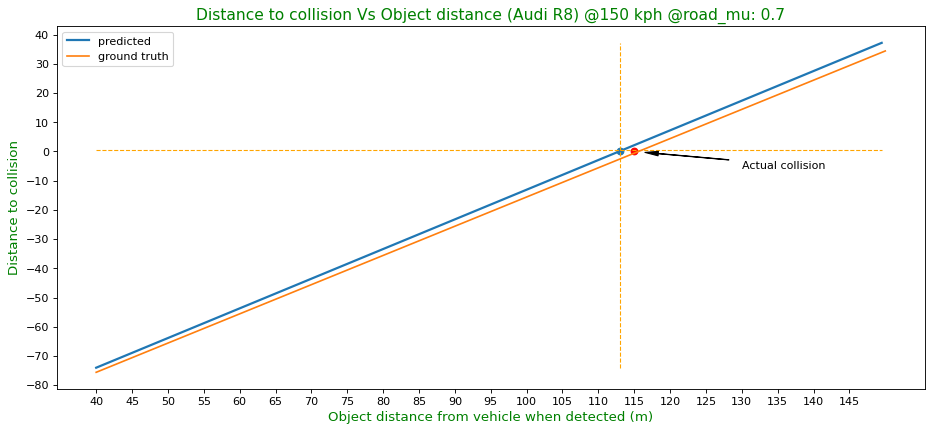

In [60]:
# Plot Probablity of collision Vs Sensor Range for Audi R8 @150 kph
import matplotlib.pyplot as plt

y_audi = predictions_audi
x = full_range
x_ticks = np.arange(obj_dist_min, obj_dist_max, 5)
y_ticks = np.arange(-200, 200, 10)

x_real = [40,50,60,70,80,90,100,110,120,130,140,150]
y_real = [-75.59,-65.59,-55.59,-45.59,-35.59,-25.59,-15.59,-5.59, 4.4, 14.4, 24.4, 34.4]

y_ref = [0.5]*len(x)
x_ref = [safe_range_audi[0]]*len(y_audi)

plt.figure(1, figsize=(14, 6), dpi=80)
plt.xlabel('Object distance from vehicle when detected (m)', fontsize=12, color='green')
plt.ylabel('Distance to collision', fontsize=12, color='green')
plt.title('Distance to collision Vs Object distance (Audi R8) @150 kph @road_mu: 0.7', fontsize=14, color='green')
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.plot(x, y_audi, linewidth=2, label="predicted")
plt.plot(x, y_ref, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_ref, y_audi, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_real, y_real, label="ground truth")
plt.scatter(safe_range_audi[0], 0)
plt.scatter(115, 0, color='red') # sensor range when actual collision occurs
plt.annotate("Actual collision", xy=(115,0), xytext=(130, -6), arrowprops=dict(facecolor="black", width=0.2, headwidth=4, shrink=0.1))
plt.legend(loc = 'upper left')
plt.show()

From the plot above, it can be seen that the accuracy in predicting the vehcile's distance to collision or in other words the recommended safety distance before a collision in a given condition is very high for a broad speed range. The trend is quite linear.

#### Parameter: Brakes (Pist_f.area)

Task: Predict vehicle front brake piston area (m^2) at which collision doesn't occur in the given condition

In [81]:
# Varying pf_area
body_mass = 1424.2
cogx = 2.267
target_speed = 150 # in kph
react_time = 0.2 # driver braking react time
road_mu = 0.7
mc_area = 3.5
boo_ampli = 5.5
pf_area = 25
obj_dist = 118
pedal_ratio = 3.5
tire_rr = 0.03
test_feature = [body_mass, cogx, obj_dist, react_time, road_mu, target_speed, tire_rr, pedal_ratio, boo_ampli, mc_area, pf_area, 0.12, 14, 0.12, 45]
max_val = 30
min_val = 10 
full_range = np.arange(min_val, max_val, 0.1)

safe_val_audi = []
df = pd.DataFrame()

for val in full_range:
    test_feature[10] = val
    series = pd.Series(test_feature)
    df = df.append(series, ignore_index=True)
    
features = df.to_numpy()
predictions_audi = model_ann.predict(features)

for i in range(0, len(full_range)):
    if predictions_audi[i] > 0:
        safe_val_audi.append(full_range[i])

print('For the Audi R8 - the front brake piston area (m^2) at which collision does not occur for target vehicle speed', target_speed, 'kph is: ', min(safe_val_audi), 'm^2')

For the Audi R8 - the front brake piston area (m^2) at which collision does not occur for target vehicle speed 150 kph is:  17.99999999999997 m^2


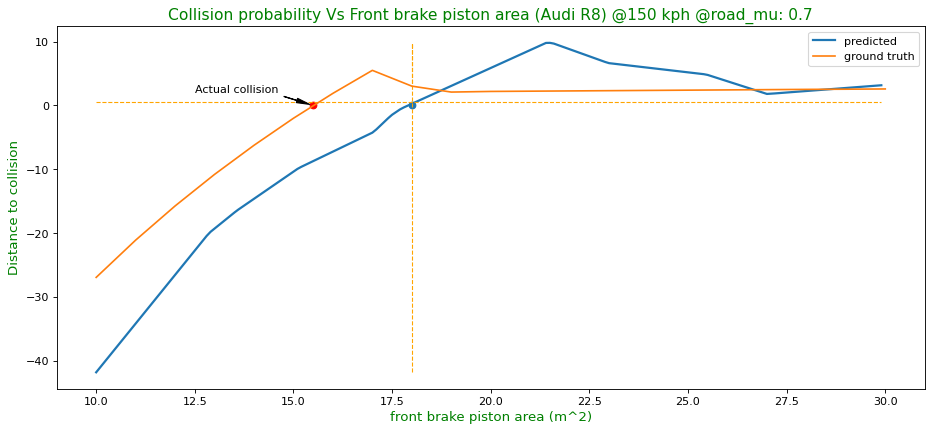

In [56]:
# Plot Probablity of collision Vs front brake piston area for Audi R8 @150 kph
import matplotlib.pyplot as plt

y_audi = predictions_audi
x = full_range

x_real = range(10, 31)
y_real = [-26.915, -21.083, -15.73, -10.79, -6.233, -2, 1.9, 5.5, 3.03, 2.1, 2.2, 2.24, 2.28, 2.32, 2.36, 2.4, 2.44, 2.48, 2.52, 2.55, 2.588]

y_ref = [0.5]*len(x)
x_ref = [safe_val_audi[0]]*len(y_audi)

plt.figure(1, figsize=(14, 6), dpi=80)
plt.xlabel('front brake piston area (m^2)', fontsize=12, color='green')
plt.ylabel('Distance to collision', fontsize=12, color='green')
plt.title('Collision probability Vs Front brake piston area (Audi R8) @150 kph @road_mu: 0.7', fontsize=14, color='green')

plt.plot(x, y_audi, linewidth=2, label="predicted")
plt.plot(x, y_ref, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_ref, y_audi, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_real, y_real, label="ground truth")
plt.scatter(safe_val_audi[0], 0)
plt.scatter(15.5, 0, color='red') # sensor range when actual collision occurs
plt.annotate("Actual collision", xy=(15.5,0), xytext=(12.5, 2), arrowprops=dict(facecolor="black", width=0.2, headwidth=4, shrink=0.1))
plt.legend()
plt.show()

In the non-linear graph above it can be seen that recommendation for brake piston area is not as high as desired. This is expected because the dataset covers a short range of this brake parameter. This means, for a better recommendation accuracy here, we will require more data points covering a broader range of brake parameters.
Interesting, the shape of the two curves suggest the model has captured the brake system dynamics, which is a good sign.

#### Parameter: Road mu

Task: Predict road mu at which collision doesn't occur in the given condition

In [83]:
# Varying road_mu
body_mass = 1424.2
cogx = 2.267
target_speed = 150 # in kph
react_time = 0.2 # driver braking react time
road_mu = 0.7
mc_area = 3.5
boo_ampli = 5.5
pf_area = 25
obj_dist = 130
pedal_ratio = 3.5
tire_rr = 0.03
test_feature = [body_mass, cogx, obj_dist, react_time, road_mu, target_speed, tire_rr, pedal_ratio, boo_ampli, mc_area, pf_area, 0.12, 14, 0.12, 45]
max_val = 1.2
min_val = 0.3 
full_range = np.arange(min_val, max_val, 0.01)

safe_val_audi = []
df = pd.DataFrame()

for val in full_range:
    test_feature[4] = val
    series = pd.Series(test_feature)
    df = df.append(series, ignore_index=True)
    
features = df.to_numpy()
predictions_audi = model_ann.predict(features)

for i in range(0, len(full_range)):
    if predictions_audi[i] > 0:
        safe_val_audi.append(full_range[i])

print('For the Audi R8 - the raod mu at which collision does not occur for target vehicle speed', target_speed, 'kph is: ', min(safe_val_audi))

For the Audi R8 - the raod mu at which collision does not occur for target vehicle speed 150 kph is:  0.6100000000000003


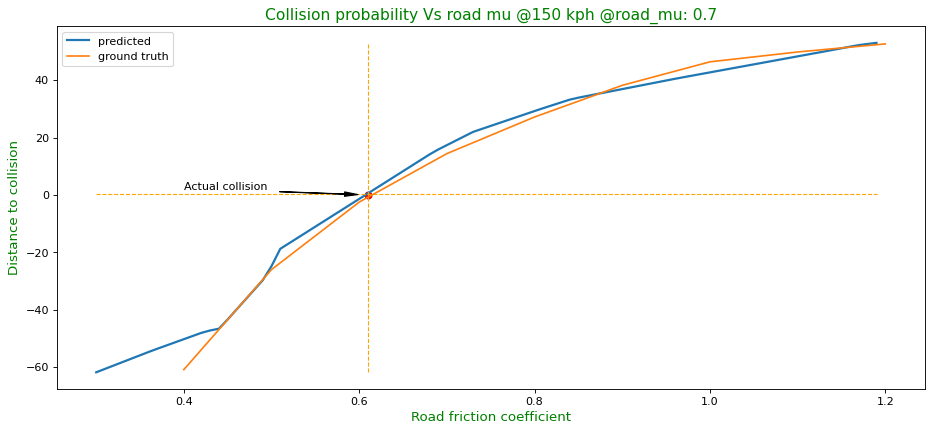

In [84]:
# Plot Probablity of collision Vs front brake piston area for Audi R8 @150 kph
import matplotlib.pyplot as plt

y_audi = predictions_audi
x = full_range

x_real = [0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]
y_real = [-60.87, -26, -2.482, 14.4167, 27.175, 38.213, 46.40, 49.84, 52.65]

y_ref = [0.5]*len(x)
x_ref = [safe_val_audi[0]]*len(y_audi)

plt.figure(1, figsize=(14, 6), dpi=80)
plt.xlabel('Road friction coefficient', fontsize=12, color='green')
plt.ylabel('Distance to collision', fontsize=12, color='green')
plt.title('Collision probability Vs road mu @150 kph @road_mu: 0.7', fontsize=14, color='green')

plt.plot(x, y_audi, linewidth=2, label="predicted")
plt.plot(x, y_ref, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_ref, y_audi, linewidth=1, linestyle='dashed', color='orange')
plt.plot(x_real, y_real, label="ground truth")
plt.scatter(safe_val_audi[0], 0)
plt.scatter(0.61, 0, color='red') # sensor range when actual collision occurs
plt.annotate("Actual collision", xy=(0.61,0), xytext=(0.4, 2), arrowprops=dict(facecolor="black", width=0.2, headwidth=4, shrink=0.1))
plt.legend()
plt.show()

The plot above shows how non-linear the relation between braking distance and road_mu is. The model has captured the effects really well and the predicted road_mu value @collision in this case is very accurate. 
Interesting to note is that below road_mu: 0.4 (outside the training data range) the prediction accuracy deviates heavily. To capture system's behaviour below road_mu:0.4, we will require to train the model on new data covering that feature range.

What is worth noting is, the training dataset was dervied from variations of feature sets in a generic vehicle (Demo Tesla) and now we are able to successfully deploy the model trained with that data on totally new vehicle models (e.g. Demo Audi R8 here)